# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Сущность обозначающая вершину дерева решений.
class Node:
    def __init__(
        self,
        probablities = None
    ):
        self.left = None
        self.right = None
        self.probabilities = probablities
        self.indexOfRootElement = None
        self.rootElementValue = -1
        self.depth = 1
        self.stopped = False

    # Добавление вершины в дерево решений.
    def addNode(self, probabilities):
        node = Node(probabilities)

        self.depth += 1

        return node

# Сущность обозначающая дерево решений.
class ModifiedDecisionTreeClassifier:
    def __init__(
        self,
        maximumDepth,
        minimumObjectsInLeaf,
        maximumTreeLeaves
    ):
        self.tree = None
        self.y = None
        self.maximumDepth = maximumDepth
        self.minimumObjectsInLeaf = minimumObjectsInLeaf
        self.maximumTreeLeaves = maximumTreeLeaves

    # Обучение модели
    def fit(self, x, y):
        self.y = y

        self.tree = Node(self.calculateProbabilities(y))

        self.splitNode(np.asarray(x), y, self.tree)

    # Подсчёт встречаемости объектов класса в выборке.
    def calculateProbabilities(self, y):
        result = []

        for typeOfY in np.unique(self.y):
            currentProbability = len(y[y == typeOfY]) / len(y)

            result.append(currentProbability)
        
        return np.array(result)

    # Подсчёт уменьшения энтропии.
    def calculateInformationGain(self, node, leftChild, rightChild):
        return entropy(node) - (len(leftChild) / len(node) * entropy(leftChild) + len(rightChild) / len(node) * entropy(rightChild))

    # Создание новой вершины дерева, используя разделение текущей по классам.
    def splitNode(self, x, y, node):
        if node.depth >= self.maximumDepth or len(x) < self.minimumObjectsInLeaf or len(set(y)) == 1:
            node.stopped = True

            return

        bestSplitIndex = None
        bestRootElementValue = None
        bestInformationGain = -1
        
        bestLeftDataframePart = []
        bestRightDataframePart = []

        leftFlagsPart = []
        rightFlagsPart = []

        for splitIndex in range(x.shape[1]):
            currentFlag = x[:, splitIndex]

            for rootElementValue in currentFlag:
                leftPart = y[currentFlag < rootElementValue]
                rightPart = y[currentFlag >= rootElementValue]

                if len(leftPart) == 0 or len(rightPart) == 0:
                    continue

                informationGain = self.calculateInformationGain(y, leftPart, rightPart)

                if informationGain > bestInformationGain:
                    bestRootElementValue, bestInformationGain, bestLeftDataframePart, bestRightDataframePart, bestSplitIndex = rootElementValue, informationGain, leftPart, rightPart, splitIndex 
                    leftFlagsPart, rightFlagsPart, currentFlag = x[currentFlag < bestRootElementValue, :], x[currentFlag >= bestRootElementValue, :], x[:, bestSplitIndex]

            if len(leftFlagsPart) < self.minimumObjectsInLeaf or len(rightFlagsPart) < self.minimumObjectsInLeaf:
                node.stopped = True

                return

            node.left = node.addNode(self.calculateProbabilities(bestLeftDataframePart))
            node.right = node.addNode(self.calculateProbabilities(bestRightDataframePart))
            node.indexOfRootElement = bestSplitIndex
            node.rootElementValue = bestRootElementValue

            self.splitNode(rightFlagsPart, bestRightDataframePart, node.right)
            self.splitNode(leftFlagsPart, bestLeftDataframePart, node.left)

    # Предсказание значения целевой функции
    def predict(self, x):
        result = []

        for element in np.asarray(x):
            currentElement = np.argmax(self.predictNode(element, self.tree))

            result.append(currentElement)

        return np.array(result)

    # Создание вершины в дереве.
    def predictNode(self, x, node):
        # print(node.indexOfRootElement)
        if node.stopped:
            return node.probabilities
        elif x[node.indexOfRootElement] > node.rootElementValue:
            return self.predictNode(x, node.right)
        else:
            return self.predictNode(x, node.left)


In [ ]:
dataset = datasets.load_iris()
xTrain, xTest, yTrain, yTest = train_test_split(dataset.data, dataset.target, test_size = 0.3, random_state = 42)

tree = ModifiedDecisionTreeClassifier(5, 5, 5)
tree.fit(xTrain, yTrain)

predictionResults = tree.predict(xTest)
round(accuracy_score(yTest, predictionResults), 4)

1.0

In [ ]:
colors = []

for i in predictionResults:
    if i == 0:
        colors.append('r')
    elif i == 1:
        colors.append('g')
    elif i == 2:
        colors.append('y')

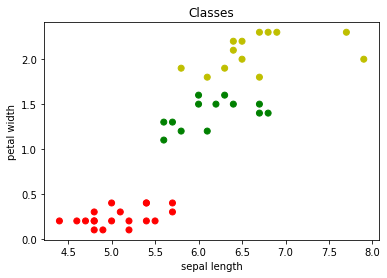

In [ ]:
plt.scatter(xTest[:, 0], xTest[:, 3], c = colors)

plt.title("Classes")
plt.xlabel("sepal length")
plt.ylabel("petal width")

plt.show()

In [ ]:
tree = ModifiedDecisionTreeClassifier(2, 1, 5)
tree.fit(xTrain, yTrain)

predictionResults = tree.predict(xTest)
round(accuracy_score(yTest, predictionResults), 4)

0.9778

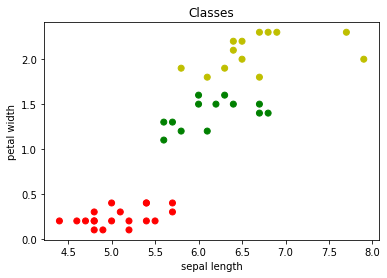

In [ ]:
plt.scatter(xTest[:, 0], xTest[:, 3], c = colors)

plt.title("Classes")
plt.xlabel("sepal length")
plt.ylabel("petal width")

plt.show()

In [ ]:
tree = ModifiedDecisionTreeClassifier(2, 1, 2)
tree.fit(xTrain, yTrain)

predictionResults = tree.predict(xTest)
round(accuracy_score(yTest, predictionResults), 4)

0.9778

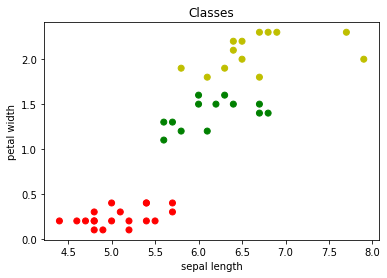

In [ ]:
plt.scatter(xTest[:, 0], xTest[:, 3], c = colors)

plt.title("Classes")
plt.xlabel("sepal length")
plt.ylabel("petal width")

plt.show()

In [ ]:
tree = ModifiedDecisionTreeClassifier(7, 7, 7)
tree.fit(xTrain, yTrain)

predictionResults = tree.predict(xTest)
round(accuracy_score(yTest, predictionResults), 4)

1.0

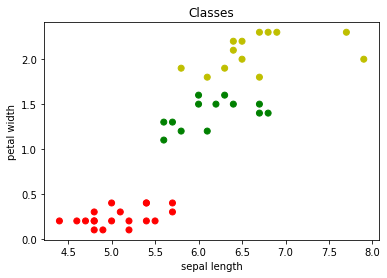

In [ ]:
plt.scatter(xTest[:, 0], xTest[:, 3], c = colors)

plt.title("Classes")
plt.xlabel("sepal length")
plt.ylabel("petal width")

plt.show()

In [ ]:
tree = ModifiedDecisionTreeClassifier(1, 1, 5)
tree.fit(xTrain, yTrain)

predictionResults = tree.predict(xTest)
round(accuracy_score(yTest, predictionResults), 4)

0.2889

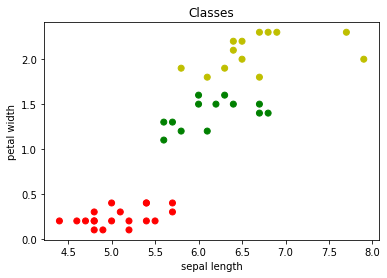

In [ ]:
plt.scatter(xTest[:, 0], xTest[:, 3], c = colors)

plt.title("Classes")
plt.xlabel("sepal length")
plt.ylabel("petal width")

plt.show()

In [ ]:
tree = ModifiedDecisionTreeClassifier(5, 2, 5)
tree.fit(xTrain, yTrain)

predictionResults = tree.predict(xTest)
round(accuracy_score(yTest, predictionResults), 4)

0.9778

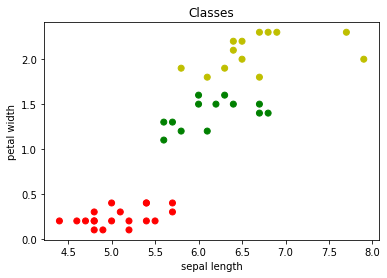

In [ ]:
plt.scatter(xTest[:, 0], xTest[:, 3], c = colors)

plt.title("Classes")
plt.xlabel("sepal length")
plt.ylabel("petal width")

plt.show()

# **Итоги**

Точность  моделей можно оценить как вполне высокую, поскольку accuracy близка к единице. При этом значения accuracy между моделями очень схожи. Мной построены несколько деревьев с использованием различных гиперпараметров. Для каждого случая построена получающаяся классификация. 

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 683 kB/s 


In [ ]:
from category_encoders import *
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataframe = pd.read_csv("/content/drive/MyDrive/churn.csv", sep = ",")
dataframe.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
class ModifiedRandomForestClassifier:
    def __init__(
            self,
            treeNumber = 100,
            maximumDepth = None,
            minimumLeaves = 1
    ):
        self.treeNumber = treeNumber
        self.maximumDepth = maximumDepth
        self.minimumLeaves = minimumLeaves
        self.forest = []

    # Обучение модели
    def fit(self, x, y):
        number = len(y)
        # Определение количества признаков
        maximumFeatures = int(x.shape[1] ** 0.5)

        # Генерация случайного леса 
        for i in range(self.treeNumber):
            seed = np.random.randint(1, 1000)

            # Отдельно рандомизируем x и y.
            # Каждому набору признаков соответствует то значение целевой функции, которое было в исходном наборе данных.
            xSample = x.sample(n = number, random_state = seed, replace = True)
            ySample = y.sample(n = number, random_state = seed, replace = True)

            currentTree = DecisionTreeClassifier(max_features = maximumFeatures, max_depth = self.maximumDepth, min_samples_leaf = self.minimumLeaves)
            currentTree.fit(xSample, ySample)

            self.forest.append(currentTree)

    # Подсчёт важности признаков.
    def calculateFlagImportance(self):
        importance = []

        for tree in self.forest:
            importance.append(tree.feature_importances_)

        return pd.DataFrame(data = importance).mean()

    # Предсказание результатов целевой функции после обучения.
    def predict(self, x):
        prediction = []

        for tree in self.forest:
            prediction.append(tree.predict(x))

        return round(pd.DataFrame(data = prediction).mean())

    


In [ ]:
# Отсев признаков, которые очевидно не влияют на итоговое решение
x = dataframe.drop(["RowNumber", "Surname", "CustomerId", "Exited"], axis = 1)
y = dataframe.Exited

x.Gender = [1 if element == "Female" else 0 for element in x.Gender]
x.Geography = TargetEncoder().fit_transform(x.Geography, y)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 42)

bestAccuracy = 0
bestMaximumTree = 0
bestMaximumDepth = 0
bestMinimumLeaves = 0

# Подбор наилучших гиперпараметров методом подбора и сравнением accuracy для разных наборов параметров.
for tree in [100, 300, 500]:
    for depth in range(1, 10):
        for leaves in range(1, 6):
            forest = ModifiedRandomForestClassifier(tree, depth, leaves)
            forest.fit(xTrain, yTrain)

            predictions = forest.predict(xTest)

            currentAccuracy = accuracy_score(yTest, predictions)

            if currentAccuracy > bestAccuracy:
                bestAccuracy = currentAccuracy
                bestMaximumTree = tree
                bestMaximumDepth = depth
                bestMinimumLeaves = leaves

In [ ]:
bestMaximumTree, bestMaximumDepth, bestMinimumLeaves

(100, 7, 2)

In [ ]:
forest = ModifiedRandomForestClassifier(100, 7, 2)
forest.fit(xTrain, yTrain)

predictions = forest.predict(xTest)
round(accuracy_score(yTest, predictions), 4)

0.866

In [ ]:
pd.DataFrame(data = np.c_[xTest.columns, forest.calculateFlagImportance()], columns = ["Feature", "Importance"]).sort_values(by = "Importance", ascending=False)

,Feature,Importance
3,Age,0.387898
6,NumOfProducts,0.317649
8,IsActiveMember,0.096198
5,Balance,0.065204
1,Geography,0.057783
0,CreditScore,0.02509
9,EstimatedSalary,0.021189
2,Gender,0.014924
4,Tenure,0.011816
7,HasCrCard,0.002249


# **Итоги**

В результате работы алгоритма получены следующие наилучшие гиперпараметры:
* Количество деревьев - 100 
* Максимальная глубина - 7, 
* минимальное количество объектов в листьях - 2

Выделим пять наиболее значимых признаков в рамках реализации. Таковыми оказались:

1.   Age
2.   NumOfProducts
3.   IsActiveMember
4.   Balance
5.   Geography



